In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

Installing dependencies...
Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 23.6 MB/s 
     |████████████████████████████████| 51 kB 8.7 MB/s 


In [3]:
import numpy as np
import pandas as pd
import collections
import numpy as np
import pretty_midi
import datetime
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython import display
from typing import Tuple
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [4]:
# constants
seq_length = 32
vocab_size = 128
NUM_EPOCHS = 2
_SAMPLING_RATE = 16000
PATH = '/content/drive/MyDrive/UCLA/ECE 147/Project/LSTM_weights/LSTM_32_single'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

root = '/content/drive/MyDrive/UCLA/ECE 147/Project'
midi_dir = os.path.join(root, 'maestro-v3.0.0')
npy_dir = os.path.join(root, 'maestro-numpy')
filenames = os.listdir(midi_dir)

In [5]:
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def get_sequences(seq_length):
    all_notes = []
    for f in filenames:
        notes = midi_to_notes(os.path.join(midi_dir, f))
        all_notes.append(notes)
    all_notes = pd.concat(all_notes)
    key_order = ['pitch', 'step', 'duration']
    data = np.stack([all_notes[key] for key in key_order], axis=1)
    data = torch.tensor(data)
    sequences = data.unfold(0, seq_length + 1, 1)

    inputs = sequences[:, :, :-1].numpy()
    labels = sequences[:, :, -1].numpy()
    return inputs, labels

def create_npy_datasets(seq_length):
    inputs_file = os.path.join(npy_dir, f'inputs.{seq_length}.npy')
    labels_file = os.path.join(npy_dir, f'labels.{seq_length}.npy')
    if os.path.exists(inputs_file) and os.path.exists(labels_file):
        print('npy datasets already exist, delete to re-generate... quitting')
        return
    if os.path.exists(inputs_file):
        os.unlink(inputs_file)
    if os.path.exists(labels_file):
        os.unlink(labels_file)
    if not os.path.exists(npy_dir):
        os.mkdir(npy_dir)
    inputs, labels = get_sequences(seq_length)
    with open(inputs_file, 'wb') as f:
        np.save(f, inputs)
    with open(labels_file, 'wb') as f:
        np.save(f, labels)

In [ ]:
#create_npy_datasets(seq_length=16)
create_npy_datasets(seq_length=32)

# PyTorch Dataset and Loader

In [6]:
class MusicDataset(Dataset):
    def __init__(self, X, y, split='train'):
        train_end = val_start = round(X.shape[0] * 0.8)
        val_end = test_start = round(y.shape[0] * 0.9)
        if split == 'train':
            X = X[:train_end]
            y = y[:train_end]
        elif split == 'val':
            X = X[val_start:val_end]
            y = y[val_start:val_end]
        elif split == 'test':
            X = X[test_start:]
            y = y[test_start:]
        else:
            raise NotImplementedError()
            
        self.X = torch.tensor(X, device=device)
        self.y = torch.tensor(y, device=device)
        self.dividend = torch.tensor([vocab_size, 1., 1.], device=device)
        self.dividend = self.dividend.reshape((3, 1))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx] / self.dividend
        y = self.y[idx]
        return x, y

In [7]:
# Load X, y out here instead of in each dataset class to save memory
with open(os.path.join(npy_dir, 'inputs.32.npy'), 'rb') as f:
    X = np.load(f)
with open(os.path.join(npy_dir, 'labels.32.npy'), 'rb') as f:
    y = np.load(f)

# Construct datasets and dataloaders
train_ds = MusicDataset(X, y, split='train')
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_ds = MusicDataset(X, y, split='val')
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
test_ds = MusicDataset(X, y, split='test')
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

# free up memory
del X; del y

In [29]:
from torch import nn

class DenseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size_lstm=50, hidden_dim_linear=50, lstm_layers=1):
        super(DenseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_size_lstm, 
                            num_layers=lstm_layers,
                            batch_first=True)
        self.flatten = nn.Flatten()
        self.bn1 = nn.BatchNorm1d(hidden_size_lstm * lstm_layers, eps=1e-05)
        self.linear = nn.Linear(hidden_size_lstm * lstm_layers, hidden_dim_linear)
        self.act = nn.ReLU()
        self.dp = nn.Dropout()
        self.bn2 = nn.BatchNorm1d(hidden_dim_linear, eps=1e-05)
        self.final = nn.Linear(hidden_dim_linear, vocab_size + 2)
        #self.final = nn.Linear(hidden_size_lstm * lstm_layers, vocab_size + 2)


    def forward(self, inputs, labels=None):
        out, h = self.lstm(inputs)
        out = self.flatten(out)
        out = self.bn1(out)
        out = self.linear(out)
        out = self.act(out)
        out = self.dp(out)
        out = self.bn2(out)
        out = self.final(out)
        return out

In [30]:
x, y = train_ds[0]
x.shape, y.shape

NameError: ignored

Input: (batch, source sequence length, feature number)
Output: (batch, target sequence length, feature number)

x.shape should be (batch size, 25, 3)
y.shap

In [10]:
# helper functions
def current_time():
  return datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

def criterion(preds, true, weights={'ce': 0.5, 'mse': 0.5}):
  mse_criterion = nn.MSELoss()
  ce_criterion = nn.CrossEntropyLoss()
  true = true.squeeze()
  ce_loss = ce_criterion(preds[:, :vocab_size], true[:, 0].long())
  ce_loss *= weights['ce']
  mse_loss = mse_criterion(preds[:, vocab_size:], true[:, 1:])
  mse_loss *= weights['mse']
  return ce_loss + mse_loss

def evaluate_loss(model, test_dl, loss_weights={'ce': 0.5, 'mse': 0.5}):
  model.eval()
  test_loss = 0.0
  with torch.no_grad():
      for i, (x, y) in enumerate(test_dl):
          x, y = x.float(), y.float()
          x, y = x.to(device), y.to(device)
          x = x.moveaxis(-1, 1)
          y = y.unsqueeze(1)
          outputs = model(x, y)
          loss = criterion(outputs, y, loss_weights)
          test_loss += loss.item()
  test_loss /= (i + 1)
  model.train()
  return test_loss

In [11]:
train_loss_hist = []
val_loss_hist = []

def train_one_epoch(epoch_index, model, optimizer, verbose=False):
    running_loss = 0.
    last_loss = 0.
    best_val_loss = float('inf')

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dl):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        inputs = torch.permute(inputs, (0, 2, 1)).float()
        outputs = model(inputs, labels)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch_index + 1}, {i + 1:5d}] train loss: {running_loss / 2000:.3f}')
            train_loss_hist.append(running_loss / 2000)
            running_loss = 0.0
                
        if i % 8000 == 0:  # print every 8000 mini-batches
            val_loss = evaluate_loss(model, val_dl)
            val_loss_hist.append(val_loss)
            print(f'[{epoch_index + 1}, {i + 1:5d}] val loss: {val_loss:.3f}')
            timestamp = current_time()
            fname = f'lstm.{timestamp}.{seq_length}.pt'
            torch.save(model.state_dict(), os.path.join(PATH, fname))
            print(f'Saved model to {fname}')
            if val_loss < best_val_loss:
                print('new best!')
                best_val_loss = val_loss
                model_path = fname

In [31]:
# PyTorch LSTM

lstm = DenseLSTM(input_dim=3, hidden_size_lstm=50, hidden_dim_linear=800, lstm_layers=seq_length)
lstm.to(device)

DenseLSTM(
  (lstm): LSTM(3, 50, num_layers=32, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn1): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=1600, out_features=800, bias=True)
  (act): ReLU()
  (dp): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Linear(in_features=800, out_features=130, bias=True)
)

In [13]:
adam = torch.optim.Adam(lstm.parameters(), lr=1e-4)

In [14]:
# train model

for epoch in range(NUM_EPOCHS):
  train_one_epoch(epoch, lstm, adam)

[1,     1] val loss: 2.489
Saved model to lstm.2022-03-14_06-31-24.32.pt
new best!
[1,  2000] train loss: 2.117
[1,  4000] train loss: 2.078
[1,  6000] train loss: 2.078
[1,  8000] train loss: 2.073
[1,  8001] val loss: 2.078
Saved model to lstm.2022-03-14_06-41-05.32.pt
new best!
[1, 10000] train loss: 2.073
[1, 12000] train loss: 2.078
[1, 14000] train loss: 2.083
[1, 16000] train loss: 2.081
[1, 16001] val loss: 2.077
Saved model to lstm.2022-03-14_06-50-42.32.pt
new best!
[1, 18000] train loss: 2.078
[1, 20000] train loss: 2.075
[1, 22000] train loss: 2.075
[1, 24000] train loss: 2.076
[1, 24001] val loss: 2.076
Saved model to lstm.2022-03-14_07-00-15.32.pt
new best!
[1, 26000] train loss: 2.077
[1, 28000] train loss: 2.079
[1, 30000] train loss: 2.077
[1, 32000] train loss: 2.079
[1, 32001] val loss: 2.090
Saved model to lstm.2022-03-14_07-09-49.32.pt
[1, 34000] train loss: 2.081
[1, 36000] train loss: 2.077
[1, 38000] train loss: 2.075
[1, 40000] train loss: 2.076
[1, 40001] val 

KeyboardInterrupt: ignored

# Evaluate on Test set

In [15]:
lstm.load_state_dict(torch.load(os.path.join(PATH, 'lstm.2022-03-14_07-19-22.32.pt')))
lstm.eval()

DenseLSTM(
  (lstm): LSTM(3, 50, num_layers=32, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn1): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Linear(in_features=1600, out_features=130, bias=True)
)

In [16]:
def predict_next_notes(notes, model, temperature=0.3):    
    x = notes.T.unsqueeze(0).float()
    y = torch.zeros((1, 1, 3), device=device).float()
    with torch.no_grad():
        preds = model(x, y)
    pitch_logits = preds[:, :vocab_size]
    if np.random.random() <= temperature:
        pitch = torch.randint(low=0, high=vocab_size+1, size=(1,))
    else:
        pitch = torch.argmax(F.softmax(pitch_logits, dim=0))
    step = preds[:, -2]
    duration = preds[:, -1]
    return pitch.item(), step.item(), duration.item()

In [17]:
# Make room in memory
del train_ds, train_dl, val_ds, val_dl

In [18]:
# Load X, y out here instead of in the dataset class to save memory/time
with open(os.path.join(npy_dir, 'inputs.32.npy'), 'rb') as f:
    X = np.load(f)
with open(os.path.join(npy_dir, 'labels.32.npy'), 'rb') as f:
    y = np.load(f)

# Load testing dataset
test_ds = MusicDataset(X, y, split='test')
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

del X; del y

In [21]:
evaluate_loss(lstm, test_dl)

2.0885457589121126

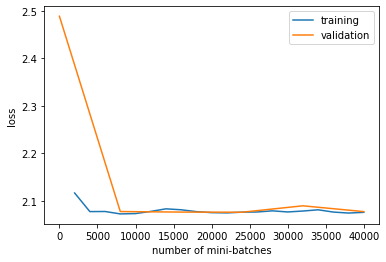

In [19]:
train_x = np.arange(2000, 40001, 2000)
val_x = np.arange(0, 40001, 8000)

plt.xlabel('number of mini-batches')
plt.ylabel('loss')
plt.plot(train_x, train_loss_hist, label='training')
plt.plot(val_x, val_loss_hist, label='validation')
plt.legend()
plt.savefig('lstm_32_single.png')

In [20]:
from google.colab import files

files.download('lstm_32_single.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate Music

In [22]:
def notes_to_midi(notes, out_file=None, instr_name='Acoustic Grand Piano', velocity=100):
    pm = pretty_midi.PrettyMIDI()
    instr = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instr_name)
    )
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end
        )
        instr.notes.append(note)
        prev_start = start

    pm.instruments.append(instr)
    if out_file:
        pm.write(out_file)
    return pm

In [23]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [28]:
generated_notes = []
num_preds = 120
prev_start = 0
input_notes, _ = test_ds[1]

for _ in range(num_preds):
    pitch, step, duration = predict_next_notes(input_notes, lstm, temperature=0.1)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = input_notes[:, 1:]
    input_note = torch.tensor(input_note) / torch.tensor([seq_length, 1, 1])
    input_note = input_note.to(device=device).unsqueeze(1)
    input_notes = torch.cat((input_notes, input_note), dim=1)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=('pitch', 'step', 'duration', 'start', 'end'))
pm = notes_to_midi(generated_notes)
display_audio(pm)